# Educational Raytracer

Simple educational raytracer mainly focused on code readability and understanding the basic principles of raytracing.
We are going to go through the each step and by the end we will have a simple raytracer where you can create your own world and render it.

# Table of Content
1. import libraries
2. define basic classes for mathematical operations using Vec3 class
3. Material and Light class
4. Ray class
5. Hit record class
6. Objects - Sphere, Plane, Mesh
7. World
8. Shading
9. Camera
10. helper functions for ray color and reflection
11. Render function
12. Create world and set render settings
13. Render preview
14. Render final image and save to file
15. Display final image
16. More theory
17. Next steps TODOs

## 1. import libraries

In [3]:
# import standard libraries and others
from __future__ import annotations
from IPython.display import Image, display
from typing import Tuple
from random import random
from time import time
from tqdm.notebook import tqdm
from math import sqrt, tan, radians, pi
from dataclasses import dataclass, field

# image handling
from src import convert_ppm_to_png, write_ppm, Resolution
# vec3 math
from src import Vertex, Vector, Color
# lights
from src import Light, PointLight, AmbientLight
# saving progress
from src import PickleManager

pm = PickleManager(directory="./pickle_data", verbose=True)


# 3. Material and Light class
## When creating scenes we want to separate items to 3 main categories:
- Objects: represent scene geometry - Sphere, Plane, Mesh for now
- Materials: represent surface properties - albedo, reflectivity
- Lights: represent light sources - position, color, intensity

## Material class and material initialization
- Material class to define surface properties like albedo (base color) and reflectivity (mirror-like) of the material


In [4]:
from dataclasses import replace

@dataclass
class Material:
    """
    Material properties for surface shading.
    mirror - 0 <= mirror <= 1
    albedo - base color of the material
    """
    base_color: Color = field(default_factory=lambda: Color.custom_rgb(255,255,255))
    reflectivity: float = 0.0 # 0=matte, 1=perfect mirror
    spec_color: Color = field(default_factory=lambda: Color.custom_rgb(255,255,255))
    shininess: float = 32.0 # specular exponent for shininess
    emission: Color = field(default_factory=lambda: Color(0.0, 0.0, 0.0))
    transparency: float = 0.0 # 0=opaque, 1=fully transparent
    ior: float = 1.5   # index of refraction
    metallic: float = 0.0 # 0=dielectric, 1=metal


    @classmethod
    def make(cls, *, base_color: Color, spec_color: Color = Color.custom_rgb(255,255,255), **kw) -> Material:
        """
        Create a Material instance with the given base color, specular color, and additional properties.

        :param base_color: The base color of the material.
        :param spec_color: The specular color of the material (default is Color.White).
        :param kw: Additional keyword arguments for other material properties.
        :return: A Material instance.
        """
        return cls(base_color=base_color, spec_color=spec_color, **kw)

    def with_color(self, base_color: Color) -> Material:
        return replace(self, base_color=base_color)

    def with_specular(self, spec_color: Color, shininess: float | None = None) -> Material:
        return replace(self, spec_color=spec_color, shininess=shininess or self.shininess)

    def with_reflectivity(self, reflectivity: float) -> Material:
        return replace(self, reflectivity=reflectivity)

    def with_transparency(self, transparency: float, ior: float | None = None) -> Material:
        return replace(self, transparency=transparency, ior=ior or self.ior)

    def with_metallic(self, metallic: float) -> Material:
        return replace(self, metallic=metallic)

## Light class and light sources initialization
- Light class to define point light source with position and intensity for now

In [26]:

# Creation of a point light source
light_source = PointLight(position=Vertex(5, 5, 0), intensity=0.8, falloff=1.2)
ambient_light = AmbientLight(position=Vertex(0,0,0), intensity=0.0)
pm.save_lights([light_source, ambient_light])

Saved object to pickle_data/lights.pkl
[PointLight(position=Vertex(x=5, y=5, z=0), intensity=0.8, falloff=1.2),
 AmbientLight(position=Vertex(x=0, y=0, z=0), intensity=0.0, falloff=1.0)]


PosixPath('pickle_data/lights.pkl')

In [6]:
list_of_lights = pm.load_lights()

Loaded object from pickle_data/lights.pkl
[PointLight(position=Vertex(x=5, y=5, z=0), intensity=0.8, falloff=1.2),
 AmbientLight(position=Vertex(x=0, y=0, z=0), intensity=0.0, falloff=1.0)]


# 4. Ray class
Ray class representing a ray in 3D space with an origin and direction.
$$
ray(t) = origin + t * direction
$$
we need to keep this in mind when calculating intersections with objects in the scene.

- origin: starting point of the ray
- direction: normalized direction vector of the ray

In [7]:
from src import Vec3


@dataclass
class Ray:
    """
    Ray in 3D space defined by an origin and a direction.
    """

    origin: Vertex    # starting point of the ray
    direction: Vector | Vec3 # normalized direction vector

    # Point on the ray at distance t from the origin
    def point_at(self, dist: float) -> Vertex:
        """
        Calculate point along the ray at distance dist from the origin.
        :param dist: distance from the ray origin
        :return: point at that distance
        """
        return self.origin + self.direction * dist

# 4. Hit record class
HitRecord class to store intersection information.
- dist: distance from ray origin to intersection point
- p: intersection point
- n: normal at intersection point
- color: color at intersection point normalized between 0 and 1 then transformed to range 0-255 to represent RGB values

In [8]:
@dataclass
class HitPoint:
    """
    Record of a ray-object intersection.
    Stores intersection distance, point, normal, and color at thepoint.
    """
    dist: float # distance from ray origin to intersection
    point: Vertex # intersection point
    normal: Vector # normal at intersection point
    ray_dir: Vector # direction of the incoming ray
    material: Material # material properties

# 5. Define objects - Sphere, Plane, Mesh

# Sphere
Sphere class representing a sphere in 3D space.
- center and radius define the sphere's geometry as
$$
(p - C) \cdot (p - C) = r^2
$$
where C is the center, r is the radius, and p is any point on the sphere's surface.

- color defines the sphere's color
- intersect method calculates ray intersection with the sphere and return Hit if intersection occurs
- t_min and t_max define the valid range for intersection distances

## Intersection calculation

By substituting the ray equation \( \text{ray}(t) = O + tD \) into the sphere equation, we get:

$$
\|(O + t d) - C\|^2 = R^2
$$

Now we define oc = o - C (vector from ray origin to sphere center) and rewrite the equation as:

$$
\|oc + t d\|^2 = R^2
$$

Expanding the left into a dot product gives:

$$
(oc + t d) \cdot (oc + t d) = R^2
$$

$$
oc \cdot oc + 2t(oc \cdot d) + t^2 (d \cdot d) = R^2
$$

Now we can rearrange this into a standard quadratic form:

$$
(d \cdot d)t^2 + 2(oc \cdot d)t + (oc \cdot oc - R^2) = 0
$$

where:

- a = d·d
- b = 2(oc·d)
- c = oc·oc - R^2


By calculating the discriminant we are able to determine if the ray intersects the sphere or not:
$$
discriminant=b2−4ac
$$
If the discriminant is negative, there is no intersection. If it's zero or positive, we can find the intersection points using the quadratic formula:
$$
t=−b±√discriminant/2a
$$
The nearest valid intersection point is chosen based on the range [t_min, t_max].



In [9]:
@dataclass
class Sphere:
    """
    Sphere in 3D space defined by center, radius, and color.
    """
    center: Vertex # center of the sphere
    radius: float # radius of the sphere
    material: Material # material properties
    # default reflectivity is 0 (matte)

    # Ray-sphere intersection
    def intersect(self, ray: Ray, t_min=0.001, t_max=float('inf')) -> HitPoint | None:
        """
        Calculate intersection of ray with sphere.
        :param ray: Ray to test intersection with
        :param t_min: minimum valid distance for intersection
        :param t_max: maximum valid distance for intersection
        :return: Hit record if intersection occurs, else None
        """
        oc = ray.origin - self.center   # Vector from oray origin to sphere center

        # Quadratic coefficients
        a = ray.direction.dot(ray.direction) # Usually = 1 if ray.direction is normalized
        b = 2.0 * oc.dot(ray.direction) # Projection of oc onto the ray
        c = oc.dot(oc) - self.radius * self.radius # Distance^2 from ray origin to sphere surface

        discriminant = b * b - 4 * a * c
        if discriminant < 0:
            return None # no intersection - ray misses the sphere

        sqrt_disc = sqrt(discriminant)

        # Find the nearest root that lies in the acceptable range by calculating both roots using quadratic formula
        root = (-b - sqrt_disc) / (2.0 * a)
        if root < t_min or root > t_max:
            root = (-b + sqrt_disc) / (2.0 * a)
            if root < t_min or root > t_max: # Point is out of range so no valid intersection
                return None

        # Calculate intersection in 3d space
        hit_point = ray.point_at(root)

        # Calculate normal at the intersection point for lighting calculations
        normal = (hit_point - self.center) / self.radius
        if ray.direction.dot(normal) > 0.0:
            normal = -normal

        return HitPoint(dist=root, point=hit_point, normal=normal, material=self.material, ray_dir=ray.direction)


gray  = Color.custom_rgb(200, 200, 200)
red   = Color.custom_rgb(255, 0, 0)
white = Color.custom_rgb(255, 255, 255)
gold  = Color.custom_rgb(255, 215, 0)
silver= Color.custom_rgb(192, 192, 192)

mate_gray    = Material.make(base_color=gray,   reflectivity=0.0)
mate_red     = Material.make(base_color=red,    reflectivity=0.0)
glass        = Material.make(base_color=white,  reflectivity=0.1, transparency=0.9, ior=1.5)
metal_gold   = Material.make(base_color=gold,   reflectivity=0.9, metallic=1.0, shininess=100)
metal_silver = Material.make(base_color=silver, reflectivity=0.9, metallic=1.0, shininess=100)

#todo separeate to smaller functions

# Plane
Planes are used for defining infinite surfaces like ground or roof. They are defined by a point on the plane and a normal vector.
Simple to calculate intersection with ray using the plane equation:

- plane_point: a point on the plane
- normal: normal vector of the plane (should be normalized)
- material: material properties
- intersect method to calculate ray-plane intersection
- t_min and t_max define the valid range for intersection distances

Now using the plane equation we can calculate intersection with ray. The plane equation is defined as:

$$
(p - P) \cdot N = 0
$$
where P is a point on the plane, N is the normal vector, and p is any point on the plane.

We can calsulate intersection by substituting the ray equation into the plane equation and solving for t:
$$
((O + t d) - P) \cdot N = 0
$$

Rearranging gives:
$$
t = \frac{(P - O) \cdot N}{d \cdot N}
$$

In [10]:
@dataclass
class Plane:
    """
    Plane in 3D space defined by a point, normal, and color.
    """
    plane_point: Vertex # a point on the plane
    normal: Vector      # normal vector of the plane (should be normalized)
    material: Material # material properties

    def __post_init__(self):
        self.normal = self.normal.normalize()

    def intersect(self, ray: Ray, t_min=0.001, t_max=float('inf')) -> HitPoint | None:
        """
        Calculate intersection of ray with plane.
        :param ray: Ray to test intersection with
        :param t_min: minimum valid distance for intersection
        :param t_max: maximum valid distance for intersection
        :return: Hit record if intersection occurs, else None
        """
        denom = ray.direction.dot(self.normal)
        if abs(denom) < 1e-6:
            return None # Ray is parallel to the plane

        t = (self.plane_point - ray.origin).dot(self.normal) / denom
        if t < t_min or t > t_max:
            return None # Intersection is out of bounds

        hit_point = ray.point_at(t)
        normal = self.normal
        if ray.direction.dot(normal) > 0.0:
            normal = -normal

        return HitPoint(dist=t, point=hit_point, normal=normal, material=self.material, ray_dir=ray.direction)

# Triangle and Mesh
Triangles are the basic building blocks of 3D models. A mesh is a collection of triangles that form a 3D object so we define both classes here for later use.

## triangle
- 3 points defining the triangle vertices
- color of the triangle
- intersect method to calculate ray-triangle intersection using Möller–Trumbore algorithm

In [11]:
@dataclass
class Triangle:
    """
    Triangle in 3D space defined by 3 points and color.
    """
    #todo implement intersect method using Möller–Trumbore algorithm
    pass


## mesh
- list of triangles forming the mesh
- color of the mesh
- import method to load mesh from file like .obj or .stl

In [12]:
@dataclass
class Mesh:
    """
    Mesh in 3D space defined by list of triangles and color.
    """
    #todo better than last time, find some optimalization for intersect method because its soo slow
    pass

# 7. World
World is main geometry container that holds all objects in the scene and provides ray intersection functionality.
- suports Sphere, Plane, Mesh objects
-method to find closest intersection of ray with any object in the world
- if no intersection, return None

In [13]:
class World:
    """
    Container for all objects in the scene. Supports ray intersection with all objects.
    objects: list of Sphere, Plane, Mesh
    """
    def __init__(self, objects: list[Sphere | Plane | Mesh]):
        self.objects = objects

    def hit(self, ray: Ray, t_min=0.001, t_max=float('inf')) -> HitPoint | None:
        """
        Find the closest intersection of ray with any object in the world.
        """
        closest_distance = t_max
        closest_hit = None

        for obj in self.objects:
            hit = obj.intersect(ray, t_min, closest_distance)
            if hit is not None and hit.dist < closest_distance:
                closest_distance = hit.dist
                closest_hit = hit

        return closest_hit

# 8. Background
We have geometrical objects in the world but what if ray does not hit anything? We need to define a background color for such rays. Linear gradient for now.

## Linear background gradient
- map vertical direction from [-1, 1] to [0, 1] and blend between two colors based on that factor using linear interpolation

In [14]:
SKYBOX_HDR = None # path to hdr image for skybox background

def background(direction: Vector) -> Color:
    if SKYBOX_HDR is not None:
        return Color.from_hdr(SKYBOX_HDR, direction)
    # simple gradient background
    t = 0.5 * (direction.y + 1.0)
    return interpolate_color(Color.custom_rgb(135, 206, 235), Color.custom_rgb(255, 255, 255), t)



# 9 Camera

We use a **pinhole camera model** that creates rays through each pixel on the image plane. The camera is defined by its field of view (fov) and resolution. The camera is positioned at the origin (0,0,0) and looks down the negative Z-axis.

In [15]:
@dataclass
class Camera:
    """
    Simple pinhole camera model.
    fov: vertical field of view in degrees
    resolution: image resolution (width, height)
    """
    fov: float = 70.0
    resolution: Resolution = Resolution.R480p
    origin: Vertex = field(default_factory=lambda: Vertex(0, 0, 0))
    direction: Vector = field(default_factory=lambda: Vector(0, 0, -1)) # looking down -Z
    up_hint: Vector = field(default_factory=lambda: Vector(0, 1, 0)) # up direction

    def __post_init__(self):
        """
        Calculate camera basis vectors and image plane dimensions.
        :return: None
        """
        # normalize forward
        fwd = self.direction.normalize()
        # guard against collinearity with up
        if abs(fwd.dot(self.up_hint)) > 0.999:
            self.up_hint = Vector(1, 0, 0) # use right vector if collinear

        # build ONB (right, true_up, forward)
        w = (-fwd).normalize()                       # camera looks along -w
        right = self.up_hint.cross(w).normalize()
        true_up = w.cross(right)

        aspect = self.resolution.width / self.resolution.height
        theta = radians(self.fov)
        half_height = tan(theta * 0.5)
        half_width  = aspect * half_height

        self.fwd = fwd
        self.right = right
        self.up = true_up
        self.half_width = half_width
        self.half_height = half_height

    def make_ray(self, u: float, v: float) -> Ray:
        """
        u, v in [-0.5, 0.5]; (-0.5,-0.5)=bottom-left, (+0.5,+0.5)=top-right
        Image plane is 1 unit in front of the camera.
        """
        # point on image plane: origin + (-w) + x*right + y*up
        x = u * (2.0 * self.half_width)
        y = v * (2.0 * self.half_height)
        img_plane_center = self.origin + self.fwd  # 1 unit ahead
        pixel_pos = img_plane_center + self.right * x + self.up * y
        return Ray(self.origin, (pixel_pos - self.origin).normalize())

# 10 Shading and helper functions
Shading function to calculate color at intersection point (each pixel in the final image). Based on light sources and material properties. We have several components: ambient, diffuse, specular, reflection, refraction and Fresnel effect.
We will use Phong reflection model for specular highlights and Lambertian model for diffuse shading. Raytracing is recursive so we need to limit the recursion depth to avoid infinite loops. We will also add shadow rays to simulate shadows from light sources.

also we need some helper functions for shading calculations described below.

#### Clamp
- clamp scalar to [0, 1] from any range its important to keep color values in this range
- clamp each RGB component to [0, 1] for Vec3 colors
- do not allow colors to go out of range but clamping can cause los of energy so use it wisely

#### clamp vectors
- clamp each RGB component to [0, 1] for Vec3 colors
- reflect vector v about normal n

#### Reflect
- reflect function helps us to calculate perfect mirror reflection direction
- n needs to be normalized if not reflection can be scaled/biased
- v is the incoming ray direction
- decompose v into components parallel and perpendicular to n and invert the perpendicular component
$$
    v_{reflected} = v - 2(v \cdot n)n
$$
- return reflected vector fliped around the normal n

#### Refract
- Using Snell's law to calculate refraction direction when ray passes through transparent material with index of refraction (ior)
- v is the incoming ray direction
- n is the normal at the intersection point
- ior_out is the index of refraction of the medium the ray is exiting
- ior_in is the index of refraction of the medium the ray is entering
- we need to calculate the ratio of indices eta = ior_out / ior_in which tells us how much the ray bends when entering the new medium.
- Using snell's law we can calculate the cosine of the angle of incidence cos_i = -n · v (dot product). And then we can calculate sin^2(theta_t) using the formula:
$$
    sin^2(theta_t) = eta^2 * (1 - cos_i^2)
$$
from this we can determine if total internal reflection occurs (when sin^2(theta_t) > 1). If it does, we return None to indicate no refraction.

#### Fresnel Schlick approximation
- Fresnel effect describes how much light is reflected vs refracted at an interface between two media.
- Depends on the angle of incidence and the indices of refraction.
- Schlick's approximation provides a simple way to estimate this effect.
$$
    F = F_0 + (1 - F_0)(1 - cos(theta))^5
$$
- where theta is the angle between the incoming ray and the normal, and F0 is the reflectance at normal incidence (when theta = 0).

#### Linear interpolation
- linear interpolation between two values a and b by factor t in [0, 1]
- linear interpolation is useful for blending colors, positions, etc.
- works as follows:
- when t=0, returns a
- when t=1, returns b
- for values in between, returns a blend of a and b

#### Safe normalize
- we are using safe normalization to avoid division by zero for near-zero vectors but at the same time we want to keep the direction as is if its already very small

#### Light relative position
- compute normalized direction and distance from hit point to light source
- used for lighting calculations and shadow rays

#### Shadow trace
- check if point is in shadow by casting a ray toward the light source
- uses world.hit to see if ray hits any object before reaching the light source
- if it does, the point is in shadow

#### Ambient light
- simple ambient light contribution to simulate indirect lighting
- can be a constant color or based on material properties
- for now we use a constant ambient light value

#### Lambertian diffuse shading
- diffuse shading based on Lambertian reflectance model
- depends on the angle between the light direction and the surface normal
- clamped to [0, 1] to avoid negative values
- multiplied by the material's base color and light intensity
- scaled by the inverse square of the distance to the light source to simulate realistic light falloff
- also multiplied by (1 - material.metallic) to reduce diffuse contribution for metallic materials
- this is because metals reflect more light specularly and less diffusely
- for non-metallic materials (dielectrics), diffuse reflection is more prominent
- this gives a more realistic appearance to metallic surfaces

#### Phong specular highlights
- specular highlights based on Phong reflection model
- depends on the angle between the reflection direction and the view direction
- metalic materials have colored specular highlights based on their base color
- non-metallic materials have white specular highlights

#### dielectric materials
- handle refraction and reflection for transparent materials
- use Fresnel effect to blend between reflection and refraction based on angle of incidence
- trace refracted ray if refraction occurs
- trace reflected ray for the reflection component
- blend the two based on Fresnel reflectance

# Helper functions for shading calculations

In [16]:
def clamp(x: float) -> float:
    """
    Clamp scalar to [0, 1].
    0 if x < 0, 1 if x > 1, else x.
    :param x: input scalar
    """
    return 0.0 if x < 0.0 else (1.0 if x > 1.0 else x)


def clamp_vec3(v) -> Color:
    """
    Clamp each RGB component to [0, 1] for Vec3 colors.
    :param v: input Vec3 color
    :return: clamped Vec3 color
    """
    return Color(clamp(v.x), clamp(v.y), clamp(v.z))


def reflect(v: Vector, n: Vector) -> Vector:
    """
    Reflect vector v about normal n.
    :param v: incoming vector
    :param n: normal vector (must be normalized)
    :return: reflected vector
    """
    return v - n * (2.0 * v.dot(n))


def refract(v: Vector, n: Vector, ior_out: float, ior_in: float) -> Vector | None:
    """
    Refract vector v through surface with normal n using Snell's law.
    :param v: incoming vector
    :param n: normal vector at intersection (must be normalized)
    :param ior_out: index of refraction of the medium ray is exiting
    :param ior_in: index of refraction of the medium ray is entering
    :return: refracted vector or None if total internal reflection occurs
    """
    v = safe_normalize(v)
    n = safe_normalize(n)

    eta = ior_out / ior_in # ratio of indices
    cos_i = -n.dot(v) # cosine of angle of incidence

    if cos_i < 0.0: # ray is inside the medium
        n = -n
        cos_i = -cos_i
        eta = 1.0 / eta

    sin2_t = eta * eta * max(0.0, 1.0 - cos_i * cos_i) # sin^2(theta_t)
    if sin2_t >= 1.0:   # total internal reflection
        return None

    cos_t = sqrt(max(0.0, 1.0 - sin2_t)) # cosine of angle of refraction
    return v * eta + n * (eta * cos_i - cos_t) # refracted direction


def fresnel_schlick(normal: Vector, view_dir: Vector, f0: Color) -> Color:
    """
    Schlick's approximation for Fresnel reflectance.
    :param normal: surface normal (must be normalized)
    :param view_dir: view direction (toward camera, must be normalized)
    :param f0: base reflectance at normal incidence (Vec3)
    :return: Fresnel reflectance (Vec3)
    """
    normal = safe_normalize(normal)
    view_dir = safe_normalize(view_dir)  # toward camera
    cos_theta = clamp(normal.dot(view_dir))
    return f0 + (Color(1.0, 1.0, 1.0) - f0) * ((1.0 - cos_theta) ** 5)


def interpolate(a: float, b: float, t: float) -> float:
    """
    Linear interpolation between a and b by factor t in [0, 1].
    :param a: point a
    :param b: point b
    :param t: interpolation factor
    :return: interpolated value
    """
    return a * (1.0 - t) + b * t


def interpolate_color(a: Color, b: Color, t: float) -> Color:
    """
    Linear interpolation between two Vec3 by factor t in [0, 1].
    :param a: point a (Vec3)
    :param b: point b (Vec3)
    :param t: interpolation factor
    :return: interpolated Vec3
    """
    return Color(
        interpolate(a.r, b.r, t),
        interpolate(a.g, b.g, t),
        interpolate(a.b, b.b, t)
    )


def safe_normalize(v: Vector) -> Vector:
    """
    Normalize but avoid division by zero for near-zero vectors.
    :param v: input Vec3
    :return: normalized Vec3 or original if near-zero
    """
    n = v.norm()
    return v if n == 0.0 else v / n


def light_relative_position(hit: HitPoint, light: Light) -> tuple[Vector, float]:
    """
    Compute direction and distance from hit point to light source.
    :param hit: Hit record
    :param light: Light source
    :return: normalized direction to light, distance to light
    """
    light_vec = light.position - hit.point
    light_dir = safe_normalize(light_vec)
    light_dist = light_vec.norm()
    return light_dir, light_dist


def shadow_trace(hit: HitPoint, light_dir: Vector, light_dist: float, world: World) -> bool:
    """
    Check if point is in shadow by casting a ray toward the light source.
    :param hit: Hit record
    :param light_dir: direction to light source
    :param light_dist: distance to light source
    :param world: World containing all objects
    :return: True if in shadow, False otherwise
    """
    shadow_ray = Ray(hit.point + safe_normalize(hit.normal) * 1e-3, light_dir) # offset origin to avoid self-intersection
    shadow_hit = world.hit(shadow_ray, t_min=0.001, t_max=light_dist) # check if ray hits anything before reaching light
    return shadow_hit is not None # in shadow if hit something


def ambient_light(material: Material) -> Color:
    """
    Simple ambient light contribution.
    :param material: Material at hit point
    :return: ambient color (Vec3)
    """
    return material.base_color * ambient_light.intensity

def emission_light(material: Material) -> Color:
    """
    Emission light contribution from material.
    :param material: Material at hit point
    :return: emission color (Vec3)
    """
    return material.emission


def lambert_diffuse(hit: HitPoint, light_dir: Vector, shadow: float, light_source: Light) -> Color:
    """
    Lambertian diffuse shading.
    :param hit: Hit record
    :param light_dir: direction to light source
    :param shadow: 1.0 if not in shadow, 0.0 if in shadow
    :param light_source: Light source
    :return: diffuse color (Vec3) at hit point
    """
    surface_material = hit.material #gets the surface material at the hit point
    diffuse_coef = max(0.0, hit.normal.dot(light_dir)) # Lambertian cosine term
    d = (light_source.position - hit.point).norm()
    light_intensity = light_source.intensity
    diffuse = surface_material.base_color * (diffuse_coef * light_intensity * shadow * (1.0 - clamp(surface_material.metallic))) # reduce diffuse for metallic materials
    return diffuse


def phong_specular(hit_point: HitPoint, light_dir: Vector, view_dir: Vector, shadow: float) -> Color:
    """
    Phong specular shading.
    1. Calculate reflection direction Rl of light_dir about hit.normal
    2. Compute specular angle as max(0, v_dir · Rl)
    3. Raise specular angle to the power of shininess for highlight size
    4. Scale by shadow factor (0 in shadow, 1 if fully lit)
    5. Modulate by specular color and base color based on metallic property
    6. Return final specular color contribution
    :param hit_point: Hit record
    :param light_dir: direction to light source
    :param view_dir: view direction (toward camera)
    :param shadow: 1.0 if not in shadow, 0.0 if in shadow
    :return: specular color (Vec3) at hit point
    """
    surface_material = hit_point.material #gets the surface material at the hit point

    # just for robustness
    normal = safe_normalize(hit_point.normal)
    light_dir = safe_normalize(light_dir)
    view_dir = safe_normalize(view_dir)

    reflected_light = reflect(-light_dir, normal) # perfect reflection direction of light
    spec_angle = max(0.0, view_dir.dot(safe_normalize(reflected_light))) # angle between view direction and reflected light
    shininess = max(2.0, surface_material.shininess)
    ks = shadow  # base spec intensity is reduced in shadow
    spec_tint = interpolate_color(surface_material.spec_color, surface_material.base_color, clamp(surface_material.metallic)) # blend spec color with base color based on metallic
    return spec_tint * (ks * (spec_angle ** shininess)) # final specular color


def dielectric_f0(ior: float) -> float:
    """
    Calculate base reflectance F0 for dielectric materials based on index of refraction.
    :param ior: index of refraction
    :return: base reflectance F0
    """
    return ((ior - 1.0) / (ior + 1.0)) ** 2

def phong_specular_with_fresnel(hit: HitPoint, light_dir: Vector, view_dir: Vector, shadow: float) -> Color:
    """
    Phong specular shading modulated by Fresnel effect for dielectric materials.
    :param hit: Hit record
    :param light_dir: direction to light source
    :param view_dir: view direction (toward camera)
    :param shadow: 1.0 if not in shadow, 0.0 if in shadow
    :return: specular color (Vec3) at hit point
    """
    material = hit.material #gets the surface material at the hit point
    phong_spec = phong_specular(hit, light_dir, view_dir, shadow) # basic Phong specular component

    if material.ior is not None and material.ior > 1.0: # dielectric material with ior
        f0_scalar = dielectric_f0(material.ior) # base reflectance for dielectrics
        f0 = Color(f0_scalar, f0_scalar, f0_scalar) # convert to Vec3
        fresnel_reflectance = fresnel_schlick(hit.normal, view_dir, f0) # Fresnel reflectance based on angle
        return phong_spec * fresnel_reflectance # modulate Phong specular by Fresnel
    else:
        return phong_spec

# Main shading function
- combines diffuse, specular, and emission components to get final color at intersection point
- also checks for shadows by casting a ray toward the light source

In [17]:
def shade(hit: HitPoint, world: World, light_source: Light) -> Color:
    """
    Main shading function combining diffuse, specular, and emission components.
    :param hit: Hit record
    :param world: World containing all objects
    :param light_source: Light source
    :return: final color (Vec3) at hit point
    """

    view_dir = safe_normalize(-hit.ray_dir)
    light_dir, light_dist = light_relative_position(hit, light_source)
    shadow = 0.0 if shadow_trace(hit, light_dir, light_dist, world) else 1.0

    r2 = max(1e-6, light_dist*light_dist)
    light_intensity = light_source.intensity / (4.0 * pi * r2)

    diffuse  = lambert_diffuse(hit, light_dir, shadow, light_source)
    specular = phong_specular_with_fresnel(hit, light_dir, view_dir, shadow) * light_intensity
    emitted  = emission_light(hit.material)
    return clamp_vec3(diffuse + specular + emitted)

# 11 Tracing rays and helper functions

## Helper methods

In [18]:
def to_u8(v: float) -> int:
    """
    Convert float color component in [0, 1] to uint8 [0, 255].
    Apply gamma correction (gamma=2.2).
    :param v: input float color component
    :return: uint8 color component
    """
    v = max(0.0, min(1.0, v))
    v = v ** (1.0 / 2.2)
    return int(255.99 * v)


def to_u8_vec3(col: Color) -> Color:
    """
    Convert Vec3 color in [0, 1] to tuple of uint8 [0, 255].
    :param col: input Vec3 color
    :return: tuple of uint8 color components
    """
    return Color.custom_rgb(to_u8(col.r), to_u8(col.g), to_u8(col.b))


def ray_color(ray: Ray, world: World, depth: int = 3) -> Color:
    """
    Wrapper for trace function to get color for a ray.
    :param depth: maximum recursion depth
    :param ray: input ray
    :param world: World containing all objects
    :return: color (Vec3) for the ray
    """
    return trace(ray, world, depth)


def handle_reflection(ray: Ray,
                     hit: HitPoint,
                     normal: Vector,
                     material: Material,
                     throughput: float) -> tuple[Ray, float]:
    """
    Handle reflection for reflective materials.
    :param ray: incoming ray
    :param hit: Hit record
    :param normal: surface normal at hit point
    :param material: Material at hit point
    :param throughput: how much light is carried along the ray
    :return: new ray and updated throughput
    """

    # Reflect
    next_dir = reflect(ray.direction, normal).normalize()

    # Fresnel-Schlick approximation
    f0_base = Color(0.04, 0.04, 0.04) # base reflectance for dielectrics
    metallic = clamp(getattr(material, "metallic", 0.0))
    f0 = interpolate_color(f0_base, material.base_color, metallic)
    f = fresnel_schlick(normal, ray.direction, f0)

    # Effective reflectivity energy
    reflectivity = clamp(getattr(material, "reflectivity", 0.0))
    energy = max(reflectivity, (f.x + f.y + f.z) / 3.0)
    energy = clamp(energy)

    # Update throughput
    throughput = throughput * energy

    # Bias to avoid self-intersections
    bias = max(1e-4, 1e-3 * min(1.0, hit.dist))
    origin = hit.point + normal * bias

    return Ray(origin, next_dir), throughput


def handle_refraction(ray: Ray,
                     hit: HitPoint,
                     normal: Vector,
                     material: Material,
                     throughput: float) -> tuple[Ray, float]:
    """
    Handle refraction for transparent materials.
    :param ray: incoming ray
    :param hit: Hit record
    :param normal: surface normal at hit point
    :param material: Material at hit point
    :param throughput: how much light is carried along the ray
    :return: new ray and updated throughput
    """

    # Get material properties
    transparency = clamp(getattr(material, "transparency", 0.0))
    ior = getattr(material, "ior", 1.5)

    # Try refraction
    refr_dir = refract(ray.direction, normal, ior_out=1.0, ior_in=ior)

    # Update throughput by transparency
    throughput = throughput * transparency

    # Bias to avoid self-intersections
    bias = max(1e-4, 1e-3 * min(1.0, hit.dist))

    if refr_dir is None:
        next_dir = reflect(ray.direction, normal).normalize()
        origin = hit.point + normal * bias
        return Ray(origin, next_dir), throughput
    else:
        origin = hit.point - normal * bias
        return Ray(origin, refr_dir.normalize()), throughput


## Tracer

In [19]:
def russian_roulette(throughput: float, depth: int, maximal_depth: int) -> bool:
    """
    Russian roulette termination for path tracing.
    :param throughput: current throughput (how much light is carried along the ray)
    :param depth: current recursion depth
    :param maximal_depth: maximum recursion depth
    :return: True if path should be terminated, False otherwise
    """
    if depth < 3:
        return False

    q = max(0.05, 1.0 - throughput) # probability of terminating the path
    if random.random() < q:
        return True # terminate path

    throughput /= (1.0 - q)
    return False

def trace(ray: Ray, world: World, maximal_depth: int = 3) -> Color:
    """
    Trace ray through the scene and compute colors. Handles reflections and refractions up to max_depth.
    :param maximal_depth: maximum recursion depth
    :param ray: input ray
    :param world: World containing all objects
    :return: color (Vec3) for the ray
    """
    color = Color.custom_rgb(0,0,0) # accumulated color
    throughput = 1.0 # how much light is carried along the ray

    for i in range(max_depth):
        closest_hit = world.hit(ray) # find the closest intersection

        if closest_hit is None:
            color += throughput * background(ray.direction)
            break

        # direct lighting
        color += throughput * shade(closest_hit, world, light_source)

        # get material properties
        material = closest_hit.material
        reflectivity = clamp(material.reflectivity)
        transparency = clamp(material.transparency)

        # stop if no more transport
        if reflectivity <= 0.0 and transparency <= 0.0:
            break

        # check
        normal = closest_hit.normal.normalize()

        if ray.direction.dot(normal) > 0.0:
            normal = -normal

        # decide reflection vs refraction
        if reflectivity >= transparency:
            ray, throughput = handle_reflection(ray, closest_hit, normal, material, throughput)
        else:
            ray, throughput = handle_refraction(ray, closest_hit, normal, material, throughput)

    # clamp
    return Color(min(1.0, color.x), min(1.0, color.y), min(1.0, color.z))
#todo refactor and better documentation

# 12 Classic ray-tracing render loop
Now to the core of our raytracer - the render function.
- for each pixel, we generate multiple rays with slight offsets for anti-aliasing
- anti-aliasing like this can very drastically increase render time
- trace each ray through the scene - if hits we shade it, if misses we use background color
- accumulate colors and average them for final pixel color
- returning list of RGB tuples and image dimensions for saving to file

In [20]:
def render(res: Resolution = Resolution.R144p,
           fov: float = 70.0,
           world: World = None,
           cam_pos: Vertex = Vertex(0, 0, 0),
           cam_dir: Vector = Vector(0, 0, -1),
           max_depth: int = 3,
           samples_per_pixel: int = 10) -> Tuple[list[Tuple[int, int, int]], int, int]:
    """
    Render the scene from the camera's perspective.
    :param res: image resolution
    :param fov: camera field of view in degrees
    :param world: World containing all objects
    :param cam_pos: camera position
    :param cam_dir: camera direction (must be normalized)
    :param max_depth: maximum recursion depth for ray tracing
    :param samples_per_pixel: number of samples per pixel for anti-aliasing
    :return: list of RGB tuples and image dimensions (width, height)
    """

    if world is None:
        raise ValueError("World must be provided for rendering.")

    #camera setup
    cam = Camera(fov=fov, resolution=res, origin=cam_pos, direction=cam_dir)

    pixels = []

    #tdm progress bar for rendering looping over image rows
    for j in tqdm(range(res.height), desc="Rendering", unit="row"):
        # map j to v in [-0.5, 0.5]
        v_base = ((res.height - 1 - j) / (res.height - 1)) - 0.5

        for i in range(res.width):
            # map i to u in [-0.5, 0.5]
            u_base = (i / (res.width - 1)) - 0.5
            # anti-aliasing by averaging multiple samples per pixel
            acc = Color.custom_rgb(0,0,0)
            for _ in range(samples_per_pixel):
                # make random offset in pixel and jitter within pixel
                du = (random.random() - 0.5) / (res.width - 1)
                dv = (random.random() - 0.5) / (res.height - 1)
                ray = cam.make_ray(u_base + du, v_base + dv)
                # trace ray and accumulate color
                acc += ray_color(ray, world, max_depth)
            # average color
            col = acc * (1.0 / samples_per_pixel)
            # convert to uint8 and store to pixel tuple
            pixels.append((to_u8(col.x), to_u8(col.y), to_u8(col.z)))
    return pixels, res.width, res.height

# 13. Create world and render

Finally, we have everything we need to create a simple scene and render it.

## How to create a scene
- Create a list of objects (Sphere, Plane) with different materials
- Create a World instance with the object list
- use materials we defined at the start of this notebook

### predefined worlds
- world - simple scene with spheres and ground plane
- corner_box - enclosed box with various spheres and planes. Introduced by Joseph Cornell as scene to evaluate rendering software.


In [21]:
def simple_spheres() -> Tuple[World, Vector, Vector]:
    objects = [
        Plane(plane_point=Vertex(0, -1, 0), normal=Vector(0, 1, 0), material=mate_gray),
        Sphere(center=Vertex(0, 0, -5), radius=1.0, material=glass),
        Sphere(center=Vertex(2, 0, -5), radius=1.0, material=mate_red),
        Sphere(center=Vertex(-2, 0, -5), radius=1.0, material=metal_gold),
        Sphere(center=Vertex(0, -0.5, -3), radius=0.5, material=metal_silver),
    ]
    world = World(objects)
    cam_pos = Vertex(0, 1, 2)
    cam_dir = Vector(0, -0.1, -1).normalize()
    return world, cam_pos, cam_dir

# 14. Choose your desired render settings
- resolutions are as most common screen resolutions defined in resolution.py
- you can also create custom resolutions with Resolution.custom(width, height)
- fov is vertical field of view in degrees
- typical values are between 30 and 90 degrees

In [22]:
#avible resolutions are: R144p, R240p, R360p, R480p, R720p, HD, FullHD, UHD, 4K
res = Resolution.R480p
#typical values are between 30 and 90 degrees
fov = 45.0

SKYBOX_PATH = None
SKYBOX_HDR = None


world_to_render, camera_pos, camera_dir = simple_spheres()

# these settings can drastically affect render time but also quality
# Numer of bounces for each ray
max_depth = 10
# Number of samples per pixel for antialiasing
samples_per_pixel = 4


# Prewiew of the scene from the camera position

Rendering at 854x480, fov=45.0, max_depth=10, spp=4


Rendering:   0%|          | 0/144 [00:00<?, ?row/s]

Preview render took 1.74 seconds


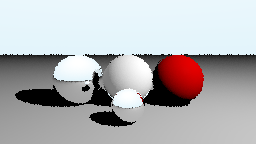

In [23]:
print(f"Rendering at {res.width}x{res.height}, fov={fov}, max_depth={max_depth}, spp={samples_per_pixel}")
start_time = time.time()
p_px, p_w, p_h = render(res=Resolution.R144p, fov=fov, world=world_to_render,
                      cam_pos=camera_pos, cam_dir=camera_dir,
                      max_depth=max_depth, samples_per_pixel=1)

write_ppm("./images/preview.ppm", p_px, p_w, p_h)
convert_ppm_to_png("./images/preview.ppm", "./images/preview.png")
print(f"Preview render took {time.time() - start_time:.2f} seconds")
display(Image(filename="./images/preview.png"))

# 15. Result
finally we can render the image and save it to a file

Rendering:   0%|          | 0/480 [00:00<?, ?row/s]

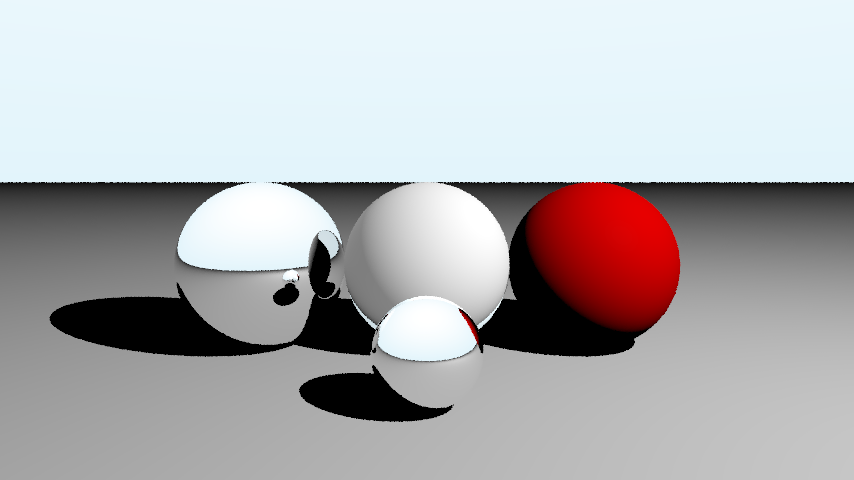


Image in resolution 854 x 480 rendered and saved to  ./images/out  and  ./images/out .png


In [24]:
px, w, h = render(res=res, fov=fov, world=world_to_render,
                  cam_pos=camera_pos, cam_dir=camera_dir,
                  max_depth=max_depth, samples_per_pixel=samples_per_pixel)

#you can set to which folder and filename you want to save the image
OUTPUT_FOLDER = "./images"
OUTPUT_FILENAME = "out"
OUTPUT_PATH = f"{OUTPUT_FOLDER}/{OUTPUT_FILENAME}"
write_ppm(OUTPUT_PATH + ".ppm", px, w, h)
convert_ppm_to_png(OUTPUT_PATH + ".ppm", OUTPUT_PATH + ".png")

display(Image(filename=OUTPUT_PATH + ".png"))

print("\nImage in resolution", w, "x", h, "rendered and saved to ", OUTPUT_PATH ," and ", OUTPUT_PATH,".png")